In [1]:
import os
import sys
import re
from pathlib import Path
from pprint import pprint

import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('Project:', PROJECT_ROOT)

# Define output directory for figures
output_dir = PROJECT_ROOT / "outputs" / "figures"
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory set to: {output_dir}")


Project: /Users/daisukeyamashiki/Code/Research/kyoto-flare-detection
Output directory set to: /Users/daisukeyamashiki/Code/Research/kyoto-flare-detection/outputs/figures


In [2]:
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

# --- 論文用のスタイル設定 (Publication Ready) ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial' # Meiryoがない場合の代替
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

print("Publication style settings applied.")


Publication style settings applied.


In [3]:
try:
    import src.flarepy_EK_Dra as ek_module
    import src.flarepy_V889_Her as v889_module
    import src.flarepy_DS_Tuc_A as ds_module
    # 他の星のモジュールも同様に追加
except ImportError as e:
    print(f"Error importing analyzer modules: {e}")
    print("Make sure the analyzer Python files (e.g., analyzer_EK_Dra.py) are in the correct path.")
    exit()


def normalize_star_folder_name(name: str) -> str:
    """フォルダ名・設定値の差異を吸収するため小文字英数字に正規化"""
    return re.sub(r"[^A-Za-z0-9]", "", name).lower()


# 2. 星の名前と、使用するFlareDetectorクラスをマッピングする辞書
#    キー: 正規化後の星フォルダ名 (Path.iterdir() の結果を normalize_star_folder_name で変換した値)
#    値: 対応するモジュール内の FlareDetector クラス
STAR_CLASS_MAP = {
    normalize_star_folder_name("EK_Dra"): ek_module.FlareDetector_EK_Dra,
    normalize_star_folder_name("V889_Her"): v889_module.FlareDetector_V889_Her,
    normalize_star_folder_name("DS_Tuc_A"): ds_module.FlareDetector_DS_Tuc_A,
    # 他の星も同様に追加: normalize_star_folder_name("StarFolderName"): corresponding_module.FlareDetector
}

# 3. 星のデータが格納されている親フォルダ
#    デフォルトでは data/TESS 配下を参照し、KYOTO_FLARE_STARS_DIR で上書き可能
DEFAULT_STARS_FOLDER = PROJECT_ROOT / "data" / "TESS"
BASE_STARS_FOLDER = Path(
    os.environ.get(
        "KYOTO_FLARE_STARS_DIR",
        str(DEFAULT_STARS_FOLDER),
    )
).expanduser()

# 4. 全ての星の解析結果を格納する辞書 (星の名前がキー)
all_stars_detectors = {}

# 5. 親フォルダ内の各星フォルダをループ
if not BASE_STARS_FOLDER.exists():
    print(f"Error: Base stars folder '{BASE_STARS_FOLDER}' not found.")
    exit()

for star_folder_path in sorted(BASE_STARS_FOLDER.iterdir()):
    if not star_folder_path.is_dir():  # フォルダでなければスキップ
        continue

    star_folder_name = star_folder_path.name
    normalized_star_name = normalize_star_folder_name(star_folder_name)

    # 6. この星に対応する FlareDetector クラスを取得
    if normalized_star_name not in STAR_CLASS_MAP:
        print(f"Warning: No FlareDetector class mapped for star folder '{star_folder_name}'. Skipping.")
        continue
    TargetFlareDetectorClass = STAR_CLASS_MAP[normalized_star_name]

    print(f"Processing star: {star_folder_name} (using {TargetFlareDetectorClass.__module__}.FlareDetector)")

    # 7. 特定の星のFlareDetectorインスタンスを格納するための辞書
    star_specific_detectors = {}

    # 星フォルダ内のファイルリスト (Path.glob を利用)
    file_list = sorted(star_folder_path.glob("*.fits"))

    for file_path in file_list:
        file_name_only = file_path.name
        s_number = None
        # ファイル名から "s" の後の4桁の数字を抽出 (例: s0001)
        for part in file_name_only.split("-"):
            if part.startswith("s") and len(part) >= 5 and part[1:5].isdigit():
                s_number = part[:5]
                break

        if s_number:
            instance_name = f"detector_{s_number}"
            try:
                # 8. 対応する FlareDetector クラスのインスタンスを作成
                #    引数は各 FlareDetector クラスの __init__ メソッドに合わせてください。
                #    ここでは共通のパラメータセットを仮定していますが、
                #    星ごとやクラスごとに異なるパラメータが必要な場合は、
                #    STAR_CLASS_MAP にパラメータ情報も持たせるなどの工夫が必要です。
                detector_params = {
                    "ene_thres_high": 1e39
                }
                detector = TargetFlareDetectorClass(
                    file=file_path,
                    process_data=True,
                    ene_thres_low=5e33,
                    **detector_params,
                )

                # データが有効かどうかの簡単なチェック
                if detector.tessBJD is not None and len(detector.tessBJD) > 0:
                    star_specific_detectors[instance_name] = detector
                else:
                    print(f"  Warning: No data or empty BJD for {file_path} in star {star_folder_name}")

            except Exception as e:
                print(f"  Error processing file {file_path} for star {star_folder_name}: {e}")
                continue  # エラーが発生したファイルはスキップ
        # else:
        #     print(f"  Info: Could not extract s_number from {file_name_only}")

    # 9. 星のインスタンス辞書が空でなければソートして格納
    if star_specific_detectors:
        try:
            sorted_star_detectors = dict(sorted(
                star_specific_detectors.items(),
                key=lambda x: x[1].tessBJD[0] if (x[1].tessBJD is not None and len(x[1].tessBJD) > 0) else float('inf')
            ))
            all_stars_detectors[star_folder_name] = sorted_star_detectors
        except IndexError:
            print(f"  Warning: Could not sort detectors for {star_folder_name} due to missing BJD data in some instances.")
            all_stars_detectors[star_folder_name] = star_specific_detectors  # ソートせずに格納
        except Exception as e:
            print(f"  Error during sorting detectors for {star_folder_name}: {e}")
            all_stars_detectors[star_folder_name] = star_specific_detectors  # ソートせずに格納

    else:
        print(f"  No valid FITS files processed or no s_number found for star: {star_folder_name}")

# 10. 結果の確認 (例)
print("--- Analysis Results ---")
for star_name_key, detectors_for_star_dict in all_stars_detectors.items():
    print(f"Star: {star_name_key}")
    if detectors_for_star_dict:
        for det_name, det_instance in detectors_for_star_dict.items():
            num_flares = 0
            if hasattr(det_instance, 'peaktime') and det_instance.peaktime is not None:
                num_flares = len(det_instance.peaktime)
            first_bjd_str = "N/A"
            if hasattr(det_instance, 'tessBJD') and det_instance.tessBJD is not None and len(det_instance.tessBJD) > 0:
                first_bjd_str = f"{det_instance.tessBJD[0]:.4f}"

            print(f"  {det_name}: First BJD = {first_bjd_str}, Number of flares = {num_flares}")
    else:
        print("No detectors successfully processed for this star.")


Processing star: DS_Tuc_A (using src.flarepy_DS_Tuc_A.FlareDetector)
Processing star: EK_Dra (using src.flarepy_EK_Dra.FlareDetector)
Processing star: V889_Her (using src.flarepy_V889_Her.FlareDetector)
--- Analysis Results ---
Star: DS_Tuc_A
  detector_s0001: First BJD = 1325.2988, Number of flares = 10
  detector_s0027: First BJD = 2036.2815, Number of flares = 13
  detector_s0028: First BJD = 2061.8541, Number of flares = 12
  detector_s0067: First BJD = 3126.6448, Number of flares = 8
  detector_s0068: First BJD = 3154.8702, Number of flares = 11
Star: EK_Dra
  detector_s0014: First BJD = 1683.3525, Number of flares = 18
  detector_s0015: First BJD = 1711.3631, Number of flares = 19
  detector_s0016: First BJD = 1738.6505, Number of flares = 11
  detector_s0021: First BJD = 1870.4359, Number of flares = 22
  detector_s0022: First BJD = 1900.3405, Number of flares = 11
  detector_s0023: First BJD = 1930.3293, Number of flares = 10
  detector_s0041: First BJD = 2419.9882, Number of f

In [4]:
print("\n--- DEBUG INFO: Checking Attributes ---")
if 'all_stars_detectors' in locals() and all_stars_detectors:
    try:
        # 辞書から最初の星の名前を取得
        first_star_name = next(iter(all_stars_detectors))
        first_star_detectors = all_stars_detectors[first_star_name]

        if first_star_detectors:
            # その星の最初のインスタンスを取得
            first_instance = next(iter(first_star_detectors.values()))
            print(f"List of attributes for one instance of star '{first_star_name}':")

            # インスタンスが持つ全ての属性名と、その中身（最初の50文字）を表示
            for attr in dir(first_instance):
                if not attr.startswith('__'): # 特殊な属性は無視
                    try:
                        value = getattr(first_instance, attr)
                        print(f"  - {attr}: {str(value)[:50]}") # 値を少しだけ表示
                    except Exception:
                        print(f"  - {attr}: (Could not get value)")

    except StopIteration:
        print("Could not find any stars or detectors to debug.")
    except Exception as e:
        print(f"An error occurred during debugging: {e}")
print("--- END DEBUG INFO ---\n")



--- DEBUG INFO: Checking Attributes ---
List of attributes for one instance of star 'DS_Tuc_A':
  - R_sunstar_ratio: 0.87
  - T_star: 5428
  - _get_star_intensity_ratio: <bound method BaseFlareDetector._get_star_intensit
  - _get_tess_response: <function BaseFlareDetector._get_tess_response at 
  - a_i: [ 0.02714841  0.06758904 -0.02476304  0.03827366  
  - amPDCSAPflux: [0.9781133  0.97864376 0.9774506  ... 0.9845172  0
  - amPDCSAPfluxerr: [0.00038245 0.0003826  0.00038241 ... 0.00038312 0
  - apply_gap_correction: <bound method BaseFlareDetector.apply_gap_correcti
  - array_amplitude: [0.05573314 0.0812002  0.06324531 0.04163891 0.053
  - array_data_name: ['tess2018206045859-s0001' 'tess2020186164531-s002
  - array_energy_ratio: [4.57160380e+33 1.27069468e+34 1.15749303e+34 7.46
  - array_flare_ratio: [0.23946785 0.39052613 0.47549861 0.19257773 0.378
  - array_observation_time: [1338.1120237  2047.94839629 2072.52695069 3140.60
  - array_per: [2.85227313 3.6297531  3.532096   3.01

DS Tuc: a=8.97e-02, b=0.99
EK Dra: a=1.92e-01, b=1.05
V889 Her: a=3.46e-01, b=0.71


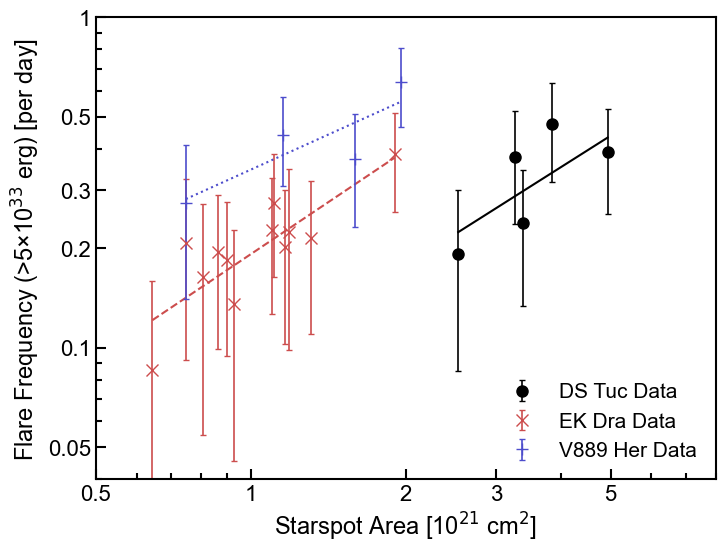

In [5]:
from scipy.optimize import curve_fit
import numpy as np

def power_law(x, a, b):
    return a * x**b

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

color_map = {'DS Tuc': 'black', 'EK Dra': (0.8, 0.3, 0.3), 'V889 Her': (0.3, 0.3, 0.8)}
marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': '+'}
linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

if 'all_stars_detectors' in locals() and all_stars_detectors:
    for star_key, detectors_dict in all_stars_detectors.items():
        display_name = star_key.replace('_', ' ').replace(' A', '')
        current_color = color_map.get(display_name, 'grey')
        current_marker = marker_map.get(display_name, 'o')
        current_linestyle = linestyle_map.get(display_name, '-')

        x_all, y_all, yerr_all = [], [], []

        # Each detector represents ONE observation period
        # Use 'starspot' (single value), 'flare_number' (single value), 'precise_obs_time' (single value)
        for det in detectors_dict.values():
            if hasattr(det, 'starspot') and hasattr(det, 'flare_number') and hasattr(det, 'precise_obs_time'):
                x_val = float(det.starspot)
                n_val = float(det.flare_number)
                t_val = float(det.precise_obs_time)

                if x_val > 0 and t_val > 0:
                    y_val = n_val / t_val  # frequency
                    yerr_val = np.sqrt(n_val + 1.0) / t_val  # Poisson error
                    x_all.append(x_val / 1e17)  # scale
                    y_all.append(y_val)
                    yerr_all.append(yerr_val)

        if len(x_all) > 1:
            x_all, y_all, yerr_all = np.array(x_all), np.array(y_all), np.array(yerr_all)
            # Filter for log plotting
            mask = (x_all > 0) & (y_all > 0)
            x_plot, y_plot, yerr_plot = x_all[mask], y_all[mask], yerr_all[mask]

            ax.errorbar(x_plot, y_plot, yerr=yerr_plot, fmt=current_marker, color=current_color,
                        label=f'{display_name} Data', capsize=2, elinewidth=1.2, markersize=8)

            try:
                popt, pcov = curve_fit(power_law, x_plot, y_plot, sigma=yerr_plot, absolute_sigma=True)
                x_fit = np.linspace(x_plot.min(), x_plot.max(), 200)
                ax.plot(x_fit, power_law(x_fit, *popt), color=current_color, linestyle=current_linestyle)
                print(f"{display_name}: a={popt[0]:.2e}, b={popt[1]:.2f}")
                plot_successful = True
            except:
                plot_successful = True

    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel(r"Flare Frequency (>5×10$^{33}$ erg) [per day]", fontsize=17)
        ax.set_xlim(0.5, 8); ax.set_ylim(0.04, 1.0)
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.set_yticks([0.05, 0.1, 0.2, 0.3, 0.5, 1.0])
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:g}"))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:g}"))
        ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10)*0.1))
        ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10)*0.1))
        ax.legend(loc='lower right', fontsize=15, frameon=False)
        plt.savefig(output_dir / 'analysis_result_freq_plot_integrated.pdf', bbox_inches='tight')
        plt.show()


DS Tuc: a=2.94e-01, b=1.44
EK Dra: a=7.31e-01, b=0.99
V889 Her: a=2.12e+00, b=1.13


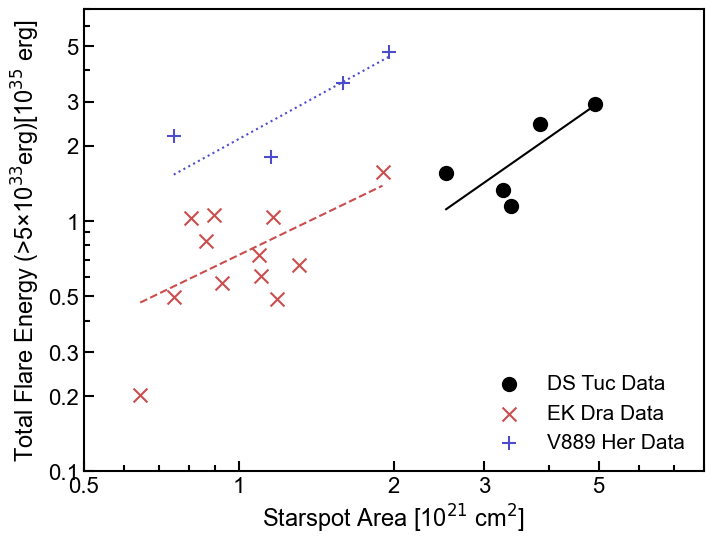

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    for star_key, detectors_dict in all_stars_detectors.items():
        display_name = star_key.replace('_', ' ').replace(' A', '')
        current_color = color_map.get(display_name, 'grey')
        current_marker = marker_map.get(display_name, 'o')
        current_linestyle = linestyle_map.get(display_name, '-')

        x_data, y_data = [], []
        # Use single-value attributes: starspot & sum_flare_energy
        for det in detectors_dict.values():
            if hasattr(det, 'starspot') and hasattr(det, 'sum_flare_energy'):
                x_val = float(det.starspot)
                y_val = float(det.sum_flare_energy)
                if x_val > 0 and y_val > 0:
                    x_data.append(x_val / 1e17)
                    y_data.append(y_val / 1e35)

        if len(x_data) > 1:
            x_arr, y_arr = np.array(x_data), np.array(y_data)
            ax.scatter(x_arr, y_arr, color=current_color, marker=current_marker, s=100, label=f"{display_name} Data")
            try:
                popt, _ = curve_fit(power_law, x_arr, y_arr)
                x_f = np.linspace(x_arr.min(), x_arr.max(), 200)
                ax.plot(x_f, power_law(x_f, *popt), color=current_color, linestyle=current_linestyle)
                print(f"{display_name}: a={popt[0]:.2e}, b={popt[1]:.2f}")
                plot_successful = True
            except: plot_successful = True

    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel(r"Total Flare Energy (>5×10$^{33}$erg)[10$^{35}$ erg]", fontsize=17)
        ax.set_xlim(0.5, 8); ax.set_ylim(0.1, 7)
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.set_yticks([0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 5.0])
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:g}"))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:g}"))
        ax.legend(loc='lower right', fontsize=15, frameon=False)
        plt.savefig(output_dir / 'analysis_result_totalene_plot_integrated.pdf', bbox_inches='tight')
        plt.show()


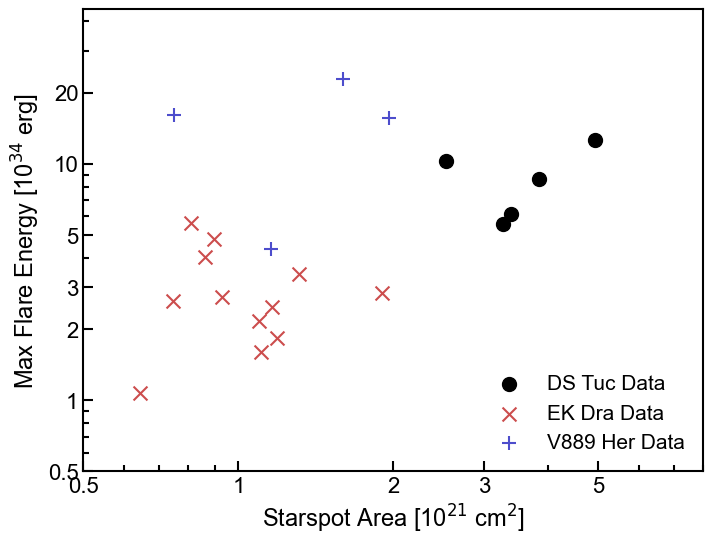

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    for star_key, detectors_dict in all_stars_detectors.items():
        display_name = star_key.replace('_', ' ').replace(' A', '')
        current_color = color_map.get(display_name, 'grey')
        current_marker = marker_map.get(display_name, 'o')

        x_data, y_data = [], []
        for det in detectors_dict.values():
            if hasattr(det, 'starspot') and hasattr(det, 'energy'):
                x_val = float(det.starspot)
                energies = det.energy
                if hasattr(energies, '__len__') and len(energies) > 0:
                    y_val = float(max(energies))
                    if x_val > 0 and y_val > 0:
                        x_data.append(x_val / 1e17)
                        y_data.append(y_val / 1e34)

        if len(x_data) > 1:
            x_arr, y_arr = np.array(x_data), np.array(y_data)
            ax.scatter(x_arr, y_arr, color=current_color, marker=current_marker, s=100, label=f"{display_name} Data")
            plot_successful = True

    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel(r"Max Flare Energy [10$^{34}$ erg]", fontsize=17)
        ax.set_xlim(0.5, 8); ax.set_ylim(0.5, 45)
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.set_yticks([0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0])
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:g}"))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:g}"))
        ax.legend(loc='lower right', fontsize=15, frameon=False)
        plt.savefig(output_dir / 'analysis_result_maxene_plot_integrated.pdf', bbox_inches='tight')
        plt.show()


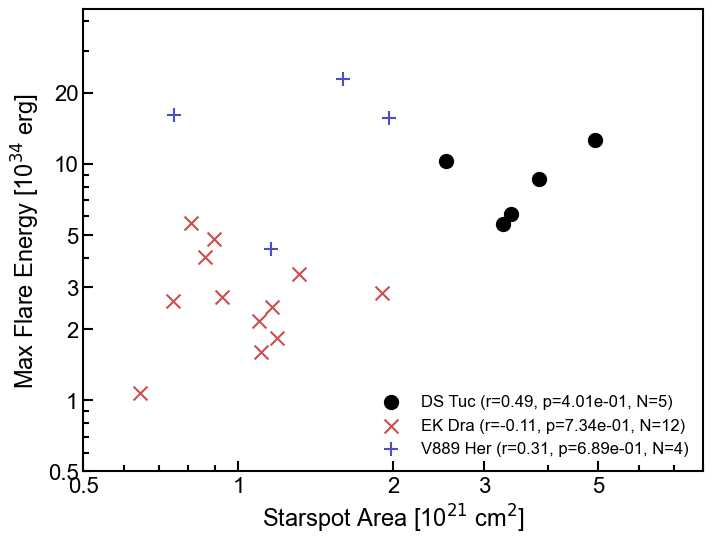

In [8]:
# Max Flare Energy with Pearson Correlation
from scipy.stats import pearsonr

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    for star_key, detectors_dict in all_stars_detectors.items():
        display_name = star_key.replace('_', ' ').replace(' A', '')
        current_color = color_map.get(display_name, 'grey')
        current_marker = marker_map.get(display_name, 'o')

        x_data, y_data = [], []
        for det in detectors_dict.values():
            if hasattr(det, 'starspot') and hasattr(det, 'energy'):
                x_val = float(det.starspot)
                energies = det.energy
                if hasattr(energies, '__len__') and len(energies) > 0:
                    y_val = float(max(energies))
                    if x_val > 0 and y_val > 0:
                        x_data.append(x_val / 1e17)
                        y_data.append(y_val / 1e34)

        if len(x_data) > 1:
            x_arr, y_arr = np.array(x_data), np.array(y_data)

            # Calculate Pearson correlation
            r_str, p_str = 'NA', 'NA'
            if len(x_arr) >= 2 and np.nanstd(x_arr) > 0 and np.nanstd(y_arr) > 0:
                try:
                    r, p = pearsonr(x_arr, y_arr)
                    r_str, p_str = f'{r:.2f}', f'{p:.2e}'
                except: pass

            label = f"{display_name} (r={r_str}, p={p_str}, N={len(x_arr)})"
            ax.scatter(x_arr, y_arr, color=current_color, marker=current_marker, s=100, label=label)
            plot_successful = True

    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel(r"Max Flare Energy [10$^{34}$ erg]", fontsize=17)
        ax.set_xlim(0.5, 8); ax.set_ylim(0.5, 45)
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.set_yticks([0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0])
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:g}"))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:g}"))
        ax.legend(loc='lower right', fontsize=12, frameon=False)
        plt.savefig(output_dir / 'analysis_result_maxene_plot_pearsonr.pdf', bbox_inches='tight')
        plt.show()


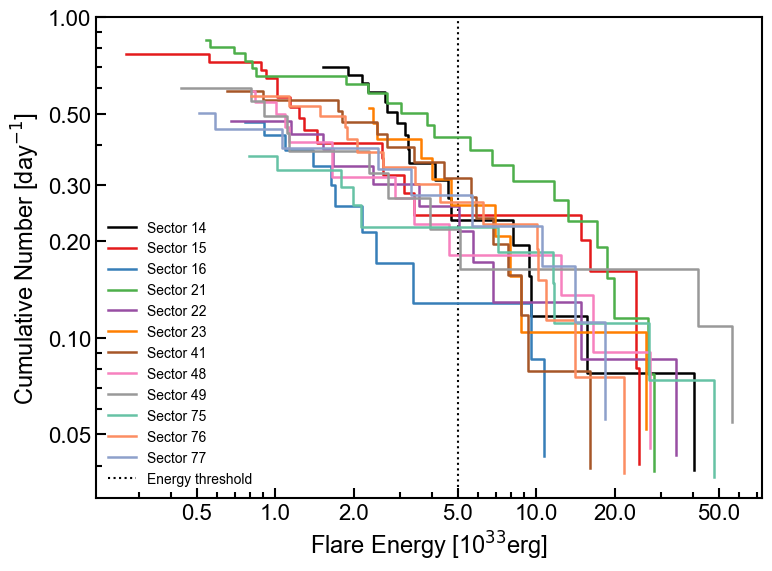

In [9]:
# Cumulative Flare Energy - EK Dra

colors_cum = [
    '#000000', '#E41A1C', '#377EB8', '#4DAF4A',
    '#984EA3', '#FF7F00', '#A65628', '#F781BF',
    '#999999', '#66C2A5', '#FC8D62', '#8DA0CB',
]

fig, ax = plt.subplots(figsize=(8, 6))

if 'EK_Dra' in all_stars_detectors:
    detector_items = list(all_stars_detectors['EK_Dra'].items())

    for i, (det_name, det) in enumerate(detector_items):
        if det.energy is None or len(det.energy) == 0:
            continue

        color = colors_cum[i % len(colors_cum)]
        energy_cor = np.sort(det.energy)
        cumenergy = np.array([len(energy_cor) - j for j in range(len(energy_cor))])
        rate = cumenergy / det.precise_obs_time

        # det_name is 'detector_s0001' -> 'Sector 1'
        try:
            s = det_name.split('_')[-1]  # 's0001'
            sector_num = int(s[1:])  # 1
            label = f'Sector {sector_num}'
        except:
            label = det_name

        ax.step(energy_cor / 1e33, rate, where='post', color=color, linewidth=1.8, label=label)

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel(r'Flare Energy [10$^{33}$erg]', fontsize=17)
    ax.set_ylabel(r'Cumulative Number [day$^{-1}$]', fontsize=17)
    ax.tick_params(labelsize=16)
    ax.axvline(x=5, color='black', linestyle='dotted', linewidth=1.5, label='Energy threshold', zorder=0)
    ax.set_xticks([0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0])
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.set_yticks([0.05, 0.1, 0.2, 0.3, 0.5, 1])
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    leg = ax.legend(loc='lower left', fontsize=10, frameon=True)
    leg.get_frame().set_alpha(0)
    plt.tight_layout()
    plt.savefig(output_dir / 'flare_cumenergy_EKDra.pdf', format='pdf', bbox_inches='tight')
    plt.show()


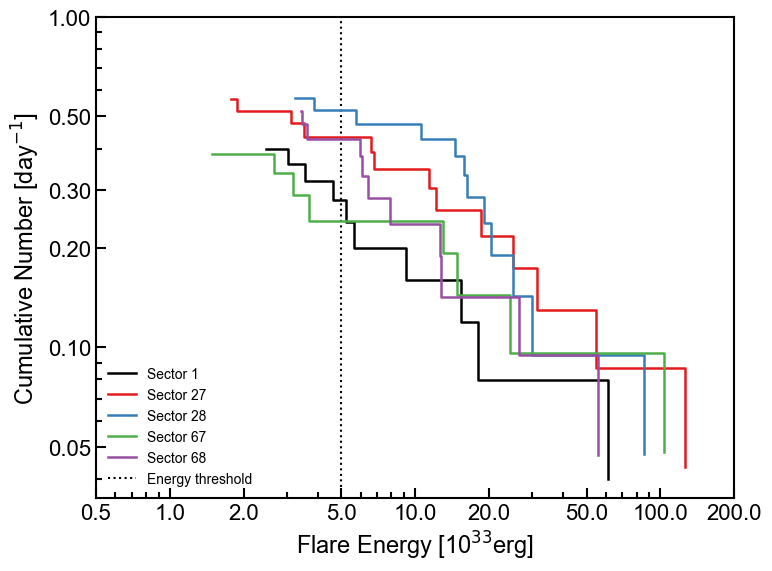

In [10]:
# Cumulative Flare Energy - DS Tuc

colors_cum = [
    '#000000', '#E41A1C', '#377EB8', '#4DAF4A',
    '#984EA3', '#FF7F00', '#A65628', '#F781BF',
    '#999999', '#66C2A5', '#FC8D62', '#8DA0CB',
]

fig, ax = plt.subplots(figsize=(8, 6))

if 'DS_Tuc_A' in all_stars_detectors:
    detector_items = list(all_stars_detectors['DS_Tuc_A'].items())

    for i, (det_name, det) in enumerate(detector_items):
        if det.energy is None or len(det.energy) == 0:
            continue

        color = colors_cum[i % len(colors_cum)]
        energy_cor = np.sort(det.energy)
        cumenergy = np.array([len(energy_cor) - j for j in range(len(energy_cor))])
        rate = cumenergy / det.precise_obs_time

        # det_name is 'detector_s0001' -> 'Sector 1'
        try:
            s = det_name.split('_')[-1]  # 's0001'
            sector_num = int(s[1:])  # 1
            label = f'Sector {sector_num}'
        except:
            label = det_name

        ax.step(energy_cor / 1e33, rate, where='post', color=color, linewidth=1.8, label=label)

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel(r'Flare Energy [10$^{33}$erg]', fontsize=17)
    ax.set_ylabel(r'Cumulative Number [day$^{-1}$]', fontsize=17)
    ax.tick_params(labelsize=16)
    ax.axvline(x=5, color='black', linestyle='dotted', linewidth=1.5, label='Energy threshold', zorder=0)
    ax.set_xticks([0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0])
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.set_yticks([0.05, 0.1, 0.2, 0.3, 0.5, 1])
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    leg = ax.legend(loc='lower left', fontsize=10, frameon=True)
    leg.get_frame().set_alpha(0)
    plt.tight_layout()
    plt.savefig(output_dir / 'flare_cumenergy_DSTuc.pdf', format='pdf', bbox_inches='tight')
    plt.show()


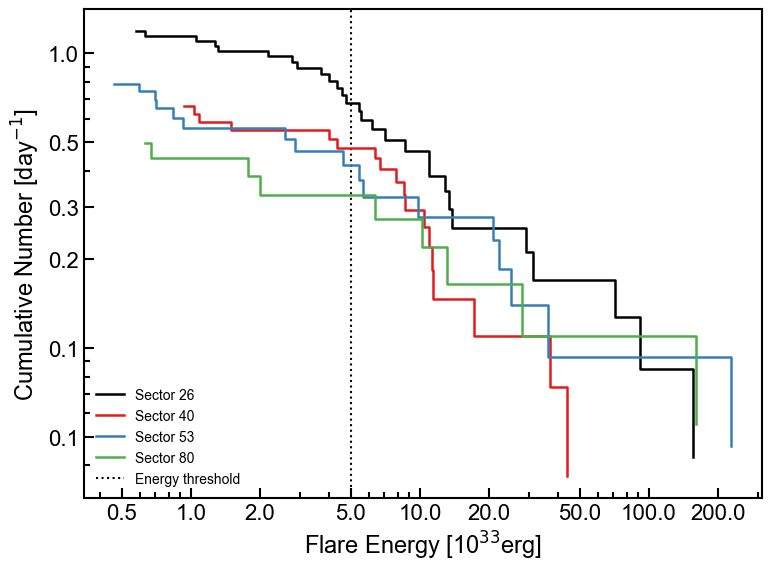

In [11]:
# Cumulative Flare Energy - V889 Her

# ===============================
# Publication Style Settings (Synced with legacy/flare_notebook.ipynb)
# ===============================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Synced colors with legacy
colors_cum = [
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A"
]

fig, ax = plt.subplots(figsize=(8, 6))

if 'V889_Her' in all_stars_detectors:
    detector_items = list(all_stars_detectors['V889_Her'].items())

    for i, (det_name, det) in enumerate(detector_items):
        if det.energy is None or len(det.energy) == 0:
            continue

        color = colors_cum[i % len(colors_cum)]
        energy_cor = np.sort(det.energy)
        cumenergy = np.array([len(energy_cor) - j for j in range(len(energy_cor))])
        rate = cumenergy / det.precise_obs_time

        # det_name is 'detector_s0001' -> 'Sector 1'
        try:
            s = det_name.split('_')[-1]  # 's0001'
            sector_num = int(s[1:])  # 1
            label = f'Sector {sector_num}'
        except:
            label = det_name

        ax.step(energy_cor / 1e33, rate, where='post', color=color, linewidth=1.8, label=label)

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel(r'Flare Energy [10$^{33}$erg]', fontsize=17)
    ax.set_ylabel(r'Cumulative Number [day$^{-1}$]', fontsize=17)
    ax.tick_params(labelsize=16)

    ax.axvline(x=5, color='black', linestyle='dotted', linewidth=1.5, label='Energy threshold', zorder=0)

    # Synced ticks and formatters with legacy
    ax.set_xticks([0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100, 200])
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())

    ax.set_yticks([0.05, 0.1, 0.2, 0.3, 0.5, 1])
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f')) # Changed from %.2f to match legacy

    leg = ax.legend(loc='lower left', fontsize=10, frameon=True)
    leg.get_frame().set_alpha(0)
    plt.tight_layout()
    plt.savefig(output_dir / 'flare_cumenergy_V889Her.pdf', format='pdf', bbox_inches='tight')
    plt.show()
